In [1]:
from google.colab import files

uploaded = files.upload()

uploaded.keys()

Saving stance_examples1.csv to stance_examples1.csv


dict_keys(['stance_examples1.csv'])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

df = pd.read_csv('stance_examples1.csv', encoding='latin1')
df['label'] = df['stance'].map({'con':0, 'pro':1})
df['text'] = df.apply(lambda r: f"[TOPIC] {r['topic']} [SEP] {r['sentence']}", axis=1)

# Make sure to adjust this path to where your 'stance-distilbert' model is located in your Google Drive.
model_path = '/content/drive/MyDrive/stance-distilbert'

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
def predict(texts):
    enc = tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors='pt')
    with torch.no_grad():
        logits = model(**enc).logits
    return torch.argmax(logits, dim=-1).cpu().numpy()

preds = predict(df['text'].tolist())
y_true = df['label'].values

acc = accuracy_score(y_true, preds)
f1m = f1_score(y_true, preds, average='macro')
print({'accuracy': acc, 'f1_macro': f1m})
print(confusion_matrix(y_true, preds))
print(classification_report(y_true, preds, target_names=['con','pro']))


{'accuracy': 0.483271375464684, 'f1_macro': 0.40041051298086944}
[[115  15]
 [124  15]]
              precision    recall  f1-score   support

         con       0.48      0.88      0.62       130
         pro       0.50      0.11      0.18       139

    accuracy                           0.48       269
   macro avg       0.49      0.50      0.40       269
weighted avg       0.49      0.48      0.39       269



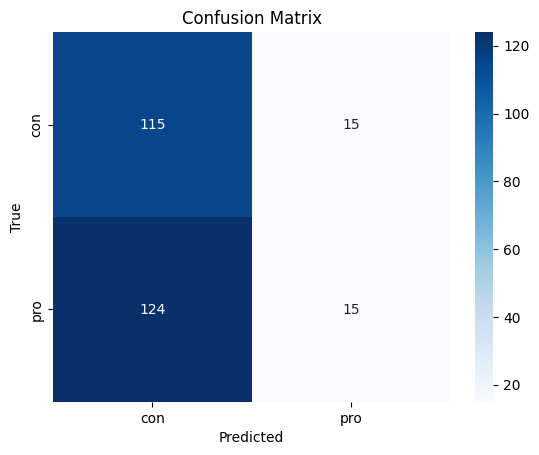

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['con','pro'], yticklabels=['con','pro'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()